# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-HES-ALM/master/main/ds-masters/content/images/hes-logo.png"> CSCI S-89: Introduction to Deep Learning
</br>

**Harvard Summer School**<br/>
**Summer 2024**<br/>
**Instructor**: Dmitry Kurochkin<br/>
**Student**: Artemio Mendoza-García</br>
**Date**: 05/AUG/2024</br>

#### Custom Autoencoder Notebook (part of the final project)


<hr style="height:2pt">

In [1]:
import os
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import tensorflow as tf
from keras import layers, models
from keras.models import load_model

from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D

import cv2
import numpy as np
from IPython.display import display, Image
import pandas as pd
# import ipywidgets as widgets
import threading
from datetime import datetime 
# from deepface import DeepFace

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3, preprocess_input

2024-08-04 13:28:01.025359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 13:28:01.035657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 13:28:01.038810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 13:28:01.047007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 13:28:02.003564: W tensorflow/compiler/tf2

#### Create Data Generator Function

In [2]:
# Paths for images
CAPTURED_IMAGE_PATH = 'images'
# Local path with the dataset CELEBA
CELEBA_IMAGE_PATH = "/mnt/d/CELEBA/img_align_celeba/"
# Local path to save noisy images
NOISY_IMAGE_PATH = "/mnt/d/CELEBA/noisy_images/"

# Ensure the paths exist and there are enough images
if not os.path.exists(CELEBA_IMAGE_PATH):
    raise FileNotFoundError(f"CELEBA_IMAGE_PATH does not exist: {CELEBA_IMAGE_PATH}")
if not os.path.exists(NOISY_IMAGE_PATH):
    raise FileNotFoundError(f"NOISY_IMAGE_PATH does not exist: {NOISY_IMAGE_PATH}")

In [3]:
IMG_SIZE = 128
num_images = 1000 #180000

noisy_image_files = os.listdir(NOISY_IMAGE_PATH)[:num_images]
noisy_image_names = [f for f in noisy_image_files]
image_names = [f.split("_")[1] for f in noisy_image_files]

In [4]:
# Check if lists are correctly populated
if len(noisy_image_names) == 0 or len(image_names) == 0:
    raise ValueError("No images found or lists are empty.")

In [5]:
print(image_names[1])
print(noisy_image_names[1])

000002.jpg
noisy_000002.jpg


In [6]:
import gc
# Delete unnecessary variables
# Run garbage collection
gc.collect()

0

In [7]:
def data_generator_no_embeddings(image_path, noisy_image_path, image_names, noisy_image_names, batch_size, image_size=(128, 128)):
    while True:
        for start in range(0, len(image_names), batch_size):
            end = min(start + batch_size, len(image_names))
            batch_image_names = image_names[start:end]
            batch_noisy_image_names = noisy_image_names[start:end]
            original_images = []
            noisy_images = []
            for original_name, noisy_name in zip(batch_image_names, batch_noisy_image_names):
                orig_path = os.path.join(image_path, original_name)
                noisy_path = os.path.join(noisy_image_path, noisy_name)
                if not os.path.exists(orig_path):
                    print(f"Original image path does not exist: {orig_path}")
                    continue
                if not os.path.exists(noisy_path):
                    print(f"Noisy image path does not exist: {noisy_path}")
                    continue
                try:
                    orig_img = cv2.imread(orig_path)
                    noisy_img = cv2.imread(noisy_path)
                    if orig_img is None:
                        print(f"Failed to read original image: {orig_path}")
                    if noisy_img is None:
                        print(f"Failed to read noisy image: {noisy_path}")
                    if orig_img is not None and noisy_img is not None:
                        orig_img = cv2.resize(orig_img, image_size)
                        noisy_img = cv2.resize(noisy_img, image_size)
                        original_images.append(orig_img)
                        noisy_images.append(noisy_img)
                except Exception as e:
                    print(f"Error reading images: {e}")
                    continue
            if original_images and noisy_images:  # Only yield if we have valid images
                original_images = np.array(original_images).astype('float32') / 255.0
                noisy_images = np.array(noisy_images).astype('float32') / 255.0
                yield noisy_images, original_images

In [8]:
# Create TensorFlow dataset without embeddings
def create_tf_dataset_no_embeddings(generator_func, image_path, noisy_image_path, image_names, noisy_image_names, batch_size, image_size=(128, 128)):
    return tf.data.Dataset.from_generator(
        lambda: generator_func(image_path, noisy_image_path, image_names, noisy_image_names, batch_size, image_size),
        output_signature=(
            tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32)
        )
    ).prefetch(tf.data.experimental.AUTOTUNE)

In [11]:
# Define paths and parameters
batch_size = 128

tf_dataset = create_tf_dataset_no_embeddings(
    data_generator_no_embeddings, 
    CELEBA_IMAGE_PATH, 
    NOISY_IMAGE_PATH, 
    image_names, 
    noisy_image_names, 
    batch_size, 
    image_size=(IMG_SIZE, IMG_SIZE)
)

In [12]:
# Validate image names and paths
for original_name, noisy_name in zip(image_names[:10], noisy_image_names[:10]):  # Check first 10 for quick validation
    orig_path = os.path.join(CELEBA_IMAGE_PATH, original_name)
    noisy_path = os.path.join(NOISY_IMAGE_PATH, noisy_name)
    if not os.path.isfile(orig_path):
        print(f"Original image not found: {orig_path}")
    if not os.path.isfile(noisy_path):
        print(f"Noisy image not found: {noisy_path}")

### Define Model 

In [13]:
def create_restoration_model(input_shape):
    # Encoder
    encoder_inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 64x64
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 32x32
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 8x8

    # Decoder
    x = layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 16x16
    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 32x32
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 64x64
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)  # 128x128
    decoder_outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=encoder_inputs, outputs=decoder_outputs)
    return model

#### Compile

In [14]:
input_shape = (IMG_SIZE, IMG_SIZE, 3)  # Adjust input shape to 128x128x3
model = create_restoration_model(input_shape)
model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     2,359,808 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,461,251 (20.83 MB)

 Trainable params: 5,461,251 (20.83 MB)

 Non-trainable params: 0 (0.00 B)

### Train Model using TensorFlow DataSet

In [45]:
# Early Stopping
patience = 1

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=patience, 
    restore_best_weights=True,
    verbose=1)

# Fit the model
history = model.fit(
    tf_dataset,
    steps_per_epoch=len(image_names) // batch_size,
    epochs=3,
    validation_data=tf_dataset,
    validation_steps=len(image_names) // batch_size // 5,  # Assuming 20% of data for validation
    callbacks=[early_stopping]
)

Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0918 - val_loss: 0.0858
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0858 - val_loss: 0.0838
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0785 - val_loss: 0.0586
Restoring model weights from the end of the best epoch: 3.


#### Save Model and training history

In [16]:
model_name = 'final_model'
__LINUX__ = True
if __LINUX__:
    model_path   = f'/dropbox/HES/CSCI-S89/Final project/CSCI-S-89-FinalProject/models/{model_name}.h5'
    history_path = f'/dropbox/HES/CSCI-S89/Final project/CSCI-S-89-FinalProject/models/{model_name}_history.json'
else:
    model_path = f'./models/{model_name}.h5'
    history_path = f'./models/{model_name}_history.json'

In [17]:
SAVE_MODEL = False 

if SAVE_MODEL:  
    # Save the entire model to a HDF5 file
    model_v2.save(model_path)  # Save model in the SavedModel format
    
    # Save the training history
    with open(history_path, 'w') as f:
        json.dump(history_v2.history, f)

#### Load Model (only if not training!)

In [18]:
LOAD_MODEL = True 

if LOAD_MODEL:    
    # Load the model
    model = load_model(model_path, custom_objects={'mse': tf.keras.losses.MeanSquaredError()})    
    
    # Load the training history
    with open(history_path, 'r') as f:
        history = json.load(f)

In [19]:
def plot_training(history):
    # Plot the training and validation loss
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

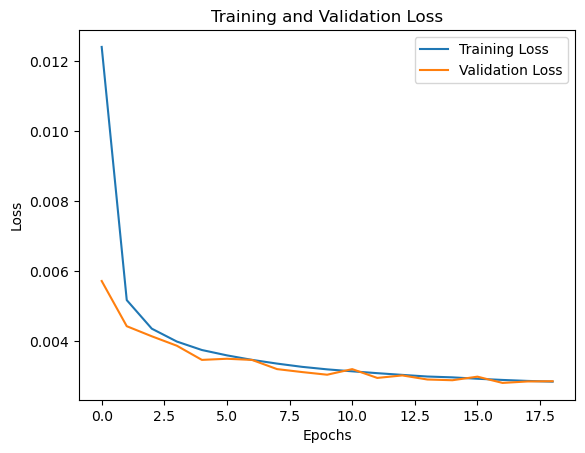

In [20]:
plot_training(history)

In [92]:
def deblurred_img(noisy_image, path='./images'):
    # get noisy image
    image_path = os.path.join(path, noisy_image)
    noisy_image = cv2.imread(image_path)
    noisy_image = cv2.resize(noisy_image, (IMG_SIZE, IMG_SIZE))
    noisy_image = noisy_image.astype('float32')/255.0

    # Add batch dimension
    noisy_image = np.expand_dims(noisy_image, axis=0)
        
    # Predict using the trained model
    deblurred_image = model.predict(noisy_image)
    
    # Remove batch dimension
    deblurred_image = np.squeeze(deblurred_image, axis=0)

    # print noisy and deblurred image
    plt.figure(figsize=(4, 4))
    plt.subplot(1,2,1)
    plt.title('Noisy Image')
    plt.imshow(cv2.cvtColor(noisy_image[0], cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.title('Deblurred Image')
    plt.imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
    plt.axis('off' )

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


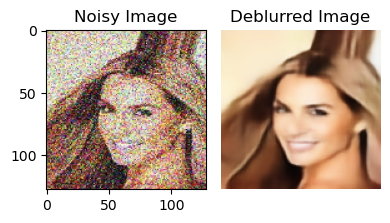

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


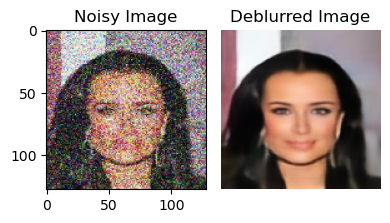

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


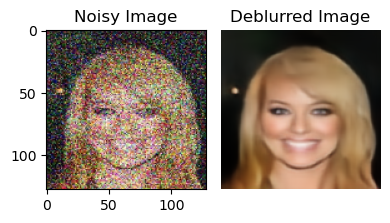

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


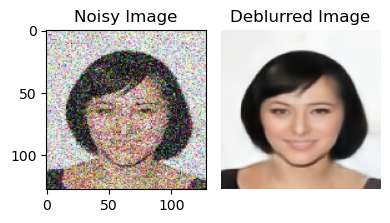

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


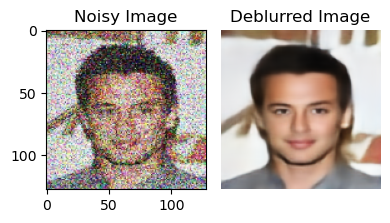

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


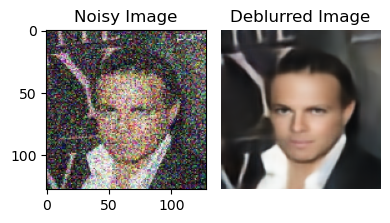

In [93]:
for my_img in ['noisy_000001.jpg','noisy_202598.jpg','noisy_000112.jpg','noisy_202593.jpg','noisy_000007.jpg','noisy_000008.jpg']:
    deblurred_img( my_img, NOISY_IMAGE_PATH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


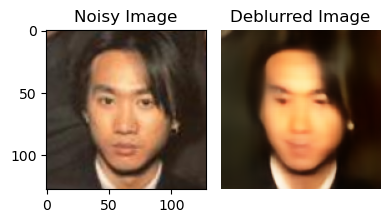

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


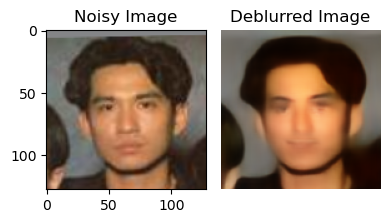

In [94]:
for my_img in ['01_00.png','01_01.png']:
    deblurred_img(my_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


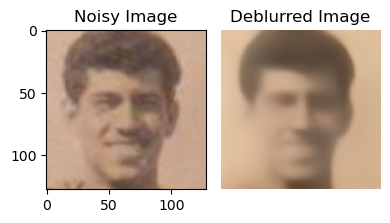

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


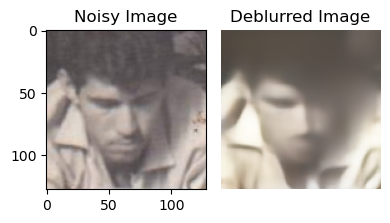

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


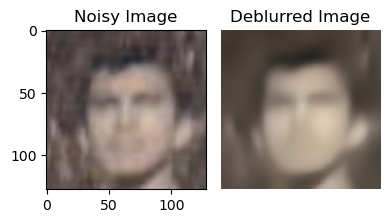

In [95]:
for my_img in ['img004_01.png','img005_01.png','img006_01.png']:
    deblurred_img(my_img)

In [25]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Define the number of images to deblur
def test_model(model=model, img_offset=0, num_images=5, path=NOISY_IMAGE_PATH, img_size=128):  
    num_images_to_deblur = num_images
    img_end = img_offset + num_images + 1
    IMG_SIZE = img_size
    
    # Load the images from the noisy path
    noisy_image_files = os.listdir(path)[img_offset: img_end]
    noisy_images = []
    
    for image_file in noisy_image_files:
        image_path = os.path.join(path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            image = image.astype('float32') / 255.0
            noisy_images.append(image)
        else:
            print(f"Failed to read image: {image_path}")
    
    # Convert list to numpy array
    noisy_images = np.array(noisy_images)
    
    # Predict using the trained model
    deblurred_images = model.predict(noisy_images)
    
    # Post-process and display/save the deblurred images
    for i in range(num_images_to_deblur):
        deblurred_image = deblurred_images[i]
        deblurred_image = (deblurred_image * 255).astype(np.uint8)
        
        # Save the deblurred image
        output_path = os.path.join("deblurred_images", f"deblurred_{i}.jpg")
        if not os.path.exists("deblurred_images"):
            os.makedirs("deblurred_images")
        cv2.imwrite(output_path, deblurred_image)
        
        # Display the deblurred image
        plt.figure(figsize=(5, 3))
        plt.subplot(1, 2, 1)
        plt.title('Noisy Image')
        plt.imshow(cv2.cvtColor(noisy_images[i], cv2.COLOR_BGR2RGB))
        plt.subplot(1, 2, 2)
        plt.title('Deblurred Image')
        plt.imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
        plt.show()

In [44]:
# test_model(model, 0)

### Compute Performance Metrics

In [71]:
__DEBUG__ = False
test_offset = 120000

# Define functions to calculate metrics
def calculate_psnr(original, deblurred):
    return psnr(original, deblurred, data_range=original.max() - original.min())

def calculate_ssim(original, deblurred, win_size=3, data_range=1.0):
    return ssim(original, deblurred, win_size=win_size, data_range=data_range, channel_axis=-1)

def calculate_fid(real_images, generated_images, epsilon=1e-6):
    # Load the InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Preprocess images to match InceptionV3 input requirements
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Get the activations for real and generated images
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)

    # Debugging statements to check the shapes of activations
    if __DEBUG__:
        print(f"Activation shape (real): {act1.shape}")
        print(f"Activation shape (generated): {act2.shape}")

    # Calculate the mean and covariance of the activations
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Debugging statements to check the shapes of mean and covariance matrices
    if __DEBUG__:
        print(f"Mean shape (real): {mu1.shape}")
        print(f"Covariance shape (real): {sigma1.shape}")
        print(f"Mean shape (generated): {mu2.shape}")
        print(f"Covariance shape (generated): {sigma2.shape}")

    # Add a small value to the diagonal of the covariance matrices to avoid singularities
    sigma1 += np.eye(sigma1.shape[0]) * epsilon
    sigma2 += np.eye(sigma2.shape[0]) * epsilon

    # Calculate the FID score
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct for numerical errors
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

# Resize images to match InceptionV3 input requirements
def resize_images(images, target_size=(299, 299)):
    resized_images = []
    for img in images:
        img = cv2.resize(img, target_size)
        resized_images.append(img)
    return np.array(resized_images)

# Load a batch of images from a directory
def load_images_from_directory(directory, num_images, img_size):
    offset = num_images 
    images = []
    filenames = os.listdir(directory)[test_offset:test_ofsset+num_images]
    for filename in filenames:
        image = cv2.imread(os.path.join(directory, filename))
        if image is not None:
            image = cv2.resize(image, (img_size, img_size))
            image = image.astype('float32') / 255.0
            images.append(image)
    return np.array(images)


In [69]:
# dataset size to compute metrics
subset = 10000

# Load the original and noisy images
original_images = load_images_from_directory(CELEBA_IMAGE_PATH, subset, IMG_SIZE)
noisy_images = load_images_from_directory(NOISY_IMAGE_PATH, subset, IMG_SIZE)

# Predict deblurred images using the trained model
deblurred_images = model.predict(noisy_images)

# Resize images to match InceptionV3 input requirements
original_images_resized = resize_images(original_images * 255)
deblurred_images_resized = resize_images(deblurred_images * 255)

# Ensure both sets of images have the same shape
assert original_images_resized.shape == deblurred_images_resized.shape, "Original and deblurred images must have the same shape"

# Calculate PSNR and SSIM for each image
psnr_scores = []
ssim_scores = []

for orig, deblur in tqdm(zip(original_images, deblurred_images), total=len(original_images), desc="Calculating PSNR and SSIM"):
    psnr_score = calculate_psnr(orig, deblur)
    ssim_score = calculate_ssim(orig, deblur)
    
    psnr_scores.append(psnr_score)
    ssim_scores.append(ssim_score)

# Calculate FID score
fid_score = calculate_fid(original_images_resized, deblurred_images_resized)

# Print the results
print(f"Average PSNR: {np.mean(psnr_scores)}")
print(f"Average SSIM: {np.mean(ssim_scores)}")
print(f"FID Score: {fid_score}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step


Calculating PSNR and SSIM: 100%|██████████████████████████████████████| 10001/10001 [00:19<00:00, 520.56it/s]
2024-08-04 14:02:26.088199: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10729192812 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 94s 296ms/step


2024-08-04 14:04:05.961170: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10729192812 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 93s 296ms/step
Average PSNR: 25.67065547089369
Average SSIM: 0.7440868020057678
FID Score: 63.556451179163915
